In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
def generate_data(K, n, mu, sigma):
    #generate vectors of means for each cluster from normal distibution
    mu_x = np.random.normal(mu, sigma, K)
    print("True means:", sorted(mu_x))
    
    #generate class assignments from categorical distribution
    c = np.random.multinomial(1, [1/K]*K, size=n)
    
    #generate data based on class assignments and each class' means
    X = np.random.normal(np.dot(c, mu_x), 1)
    
    #make pandas DF with data points and cluster number
    data = pd.DataFrame()
    data['x'] = X
    data['cluster'] = np.argmax(c, axis=1)
    return data

def plot_data(data, figsize=8):
    g = sns.FacetGrid(data, hue="cluster", palette="dark")
    g = (g.map(sns.distplot, 'x', hist=True, kde=False, norm_hist=True))
    ax = g.axes[0,0]
    ax.set_xlabel('n = %d'% n, fontsize=12)
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    #facet.set(ylim=(-8, 8), xlim=(-8, 8))
    g.fig.set_figwidth(figsize)
    g.fig.set_figheight(figsize/2)
    plt.show()

In [3]:
class CAVI(object):
    '''Univariate GMM with CAVI'''
    def __init__(self, data, K=3, sigma=1, verbose=False):
        self.X = data.x
        self.cluster = data.cluster
        self.K = K
        self.N = self.X.shape[0]
        self.sigma = sigma
        self.sigma2 = sigma**2
        self.verbose = verbose

    def _initial(self):
        #assign equal initial probabilities to each cluster
        self.phi = np.full((self.N, self.K), 1/self.K)
        #draw random initial means for each cluster from standard normal distribution
        self.m = np.random.normal(0, self.sigma, self.K)
        #set std.dev of each cluster to 1
        self.s2 = np.random.rand(self.K)
        print('Initial means')
        print(self.m)
        print('Initial std.dev')
        print(self.s2)
        
    def _cavi(self):
        # phi update
        e = np.outer(self.X, self.m) + (-0.5 * (self.m**2 + self.s2))[np.newaxis, :] #[np.newaxis, :] is to matrix
        self.phi = np.exp(e) / np.sum(np.exp(e), axis=1)[:, np.newaxis] #normalization  K*N matrix
        #m update
        self.m = np.sum(self.X[:, np.newaxis] * self.phi, axis=0)/(1.0 / self.sigma2 + np.sum(self.phi, axis=0))
        # s2 update
        self.s2 = np.sum(np.subtract.outer(self.X, self.m)**2 * self.phi, axis=0) / (1.0 / self.sigma2 + np.sum(self.phi, axis = 0))
        

    def _elbo(self):
        p1 = -np.sum((self.m**2 + self.s2) / (2 * self.sigma2))
        p2 = np.sum((np.outer(self.X, self.m) - 0.5 * np.add.outer(self.X**2, self.m**2 + self.s2))*(self.phi))
        p4 = 0.5 * np.sum(np.log(self.s2))
        p3 = -np.sum(np.log(self.phi))
         
        return p1 + p2 + p3 + p4

    def fit(self, max_iter=100, tol=0.001):
        start = time.time()
        self._initial()
        m_history = [self.m]
        s2_history = [self.s2]
        
        self.elbo_values = [self._elbo()]
        
        for iter_ in range(1, max_iter+1):
            self._cavi()
            m_history.append(self.m)
            s2_history.append(self.s2)
            self.elbo_values.append(self._elbo())
            
            if (self.verbose) & (iter_ % 5 == 0):
                print(iter_, m_history[iter_])
            if np.abs(self.elbo_values[-2] - self.elbo_values[-1]) <= tol:
                print('ELBO converged with ll %.3f at iteration %d'%(self.elbo_values[-1],
                                                                     iter_))
                break

        if iter_ == max_iter:
            print('ELBO ended with ll %.3f'%(self.elbo_values[-1]))
            
        print('Predicted means:', sorted(m_history[iter_]))
        print('Predicted std.dev:', np.sqrt(sorted(s2_history[iter_])))
        end = time.time()
        print('Time elapsed:', end - start)
        self.plot_data()
        
    def plot_data(self, figsize=8):
        self.data = pd.DataFrame()
        self.data['x'] = self.X
        self.data['cluster'] = self.cluster
        g = sns.FacetGrid(self.data, hue="cluster", palette="dark")
        g = (g.map(sns.distplot, 'x', hist=True, kde=True, norm_hist=True))
        for i in range (self.K):
            sns.distplot(np.random.normal(self.m[i], np.sqrt(self.s2[i]), self.N), color='k', hist=False, kde=True)
            
        ax = g.axes[0,0]
        ax.set_xlabel('n = %d'% self.N, fontsize=12)
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        #facet.set(ylim=(-8, 8), xlim=(-8, 8))
        g.fig.set_figwidth(figsize)
        g.fig.set_figheight(figsize/2)
        plt.show()
        

Set number of clusters

In [4]:
K = 3

Set mean and standard deviation for each cluster

In [5]:
mu = 0 
sigma = 3

Set number of observations

In [6]:
n = 1000

True means: [-5.840910927067639, 0.2736141498594593, 3.2738481998163316]


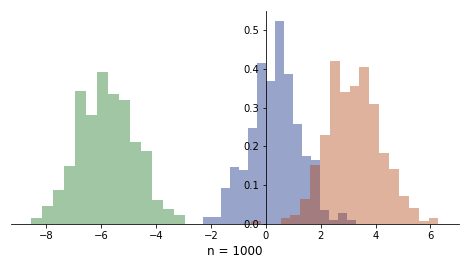

In [7]:
np.random.seed(8)
data = generate_data(K, n, mu, sigma)
plot_data(data)

Initial means
[ 0.6175946   3.50028513 -6.21791934]
Initial std.dev
[0.58585138 0.53574974 0.82745628]
ELBO converged with ll 41706.227 at iteration 14
Predicted means: [-5.798064120741263, 0.3963352212925377, 3.2288124523529547]
Predicted std.dev: [0.97456676 0.98668959 1.01281169]
Time elapsed: 0.028805017471313477


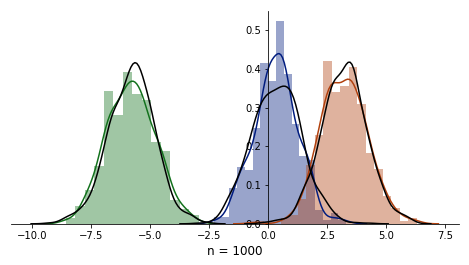

In [8]:
np.random.seed(53)
cavi = CAVI(data, K, sigma, verbose=False)
cavi.fit()

True means: [-5.840910927067639, 0.2736141498594593, 3.2738481998163316]
Initial means
[ 0.6175946   3.50028513 -6.21791934]
Initial std.dev
[0.58585138 0.53574974 0.82745628]
ELBO converged with ll 424916388.457 at iteration 22
Predicted means: [-5.840384749879916, 0.27402396818898966, 3.2729097543869727]
Predicted std.dev: [0.99968113 0.99980013 1.00042853]
Time elapsed: 192.93563103675842


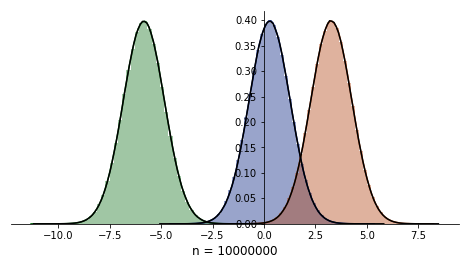

In [10]:
n = 10000000

np.random.seed(8)
data = generate_data(K, n, mu, sigma)

np.random.seed(53)
cavi = CAVI(data, K, sigma, verbose=False)
cavi.fit()